Referal https://www.tensorflow.org/tutorials/audio/music_generation

In [82]:
from IPython import display
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [83]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Download the maestro dataset of 1282 files
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

# these lines from tensor documentation above
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))
sample_file = filenames[1]
print(sample_file)

# generate a prettyMIDI object for the sample MIDI file
pm = pretty_midi.PrettyMIDI(sample_file)

Number of files: 1282
data/maestro-v2.0.0/2008/MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--1.midi


In [84]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=40):
    waveform = pm.fluidsynth(fs=float(_SAMPLING_RATE))
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [85]:
display_audio(pm)

In [86]:
print('Number of instruments:', len(pm.instruments))
for instrument in pm.instruments:
    # instrument = pm.instruments[instrument]
    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
    print('Instrument name:', instrument_name)
    for i, note in enumerate(instrument.notes[:10]):
        note_name = pretty_midi.note_number_to_name(note.pitch)
        duration = note.end - note.start
        print(f'{i}: pitch={note.pitch}, note_name={note_name},'
                f' duration={duration:.4f}')

Number of instruments: 1
Instrument name: Acoustic Grand Piano
0: pitch=73, note_name=C#5, duration=0.3021
1: pitch=72, note_name=C5, duration=0.2174
2: pitch=70, note_name=A#4, duration=0.1680
3: pitch=69, note_name=A4, duration=0.1471
4: pitch=46, note_name=A#2, duration=0.7578
5: pitch=70, note_name=A#4, duration=0.3372
6: pitch=65, note_name=F4, duration=0.2852
7: pitch=66, note_name=F#4, duration=0.3099
8: pitch=63, note_name=D#4, duration=0.2826
9: pitch=58, note_name=A#3, duration=1.6302


In [87]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=73, note_name=C#5, duration=0.3021
1: pitch=72, note_name=C5, duration=0.2174
2: pitch=70, note_name=A#4, duration=0.1680
3: pitch=69, note_name=A4, duration=0.1471
4: pitch=46, note_name=A#2, duration=0.7578
5: pitch=70, note_name=A#4, duration=0.3372
6: pitch=65, note_name=F4, duration=0.2852
7: pitch=66, note_name=F#4, duration=0.3099
8: pitch=63, note_name=D#4, duration=0.2826
9: pitch=58, note_name=A#3, duration=1.6302


In [88]:
# def midi_to_notes(midi_file: str) -> pd.DataFrame:
#   pm = pretty_midi.PrettyMIDI(midi_file)
#   notes = collections.defaultdict(list)

#   instrument_names = []
#   for instrument in pm.instruments:
#     instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
#     instrument_names.append(instrument_name)
#     # print(instrument_name)
#     # Sort the notes by start time
#     sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
#     prev_start = sorted_notes[0].start
#     # print(sorted_notes)

#     for note in sorted_notes:
#         start = note.start
#         end = note.end
#         notes['pitch'].append(note.pitch)
#         notes['start'].append(start)
#         notes['end'].append(end)
#         notes['step'].append(start - prev_start)
#         notes['duration'].append(end - start)
#         prev_start = start
  
#   return pd.DataFrame({name: np.array(value) for name, value in notes.items()}), instrument_names

In [89]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [90]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     73  1.070312  1.372396  0.000000  0.302083
1     46  1.088542  1.846354  0.018229  0.757812
2     72  1.277344  1.494792  0.188802  0.217448
3     70  1.484375  1.652344  0.207031  0.167969
4     69  1.673177  1.820312  0.188802  0.147135

In [91]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C#5', 'A#2', 'C5', 'A#4', 'A4', 'A#4', 'A#3', 'F4', 'F#4', 'D#4'],
      dtype='<U3')

### Ceate a MIDI file

In [92]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [93]:
# Assuming you already have the `notes_df` DataFrame and `instrument_name` list

# Specify the output MIDI file path
example_file = 'example.midi'

# Call the `notes_to_midi` function
example_pm = notes_to_midi(raw_notes, out_file=example_file, instrument_name=instrument_name)

# Play the generated MIDI file in ipynb
display_audio(example_pm)


### Create the training dataset

In [94]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
print("Number of notes parsed:", n_notes)

Number of notes parsed: 12982


#### Create a tf.data.Dataset from the parsed notes.

In [95]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [96]:
def create_sequences(
        dataset: tf.data.Dataset,
        seq_length: int,
        vocab_size = 128,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples"""
    seq_length = seq_length + 1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

    # Flat_map falltens the "dataset of datasets" into a dataset of tensors
    flatten = lambda x:x.batch(seq_length, drop_remainder=True) # lambda x:: Defines an anonymous function that takes an input x. and this function per se is assigned to the flatten variable
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    # For instance, if x is a list or array [a, b, c], the scaling operation i.e. division would result in [a/vocab_size, b/1.0, c/1.0].
    def scale_pitch(x):
        x = x / [vocab_size, 1.0, 1.0]
        return x
    
    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labls_dense = sequences[-1]
        labels = {key:labls_dense[i] for i, key in enumerate(key_order)} # the ley_order is a global variable

        return scale_pitch(inputs), labels
    # In Python, if you're using map from tf.data.Dataset, the map function allows you to apply a transformation to each element of the dataset.
    # Meaning you do not have to pass in an argument to the split_labels function even tho it expects an argumment
    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [97]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [98]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10]) # Change the slice here if you want to take first 2 notes
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.4375     0.         0.21223958]
 [0.4921875  0.         0.21223958]
 [0.46875    0.00260417 0.20052083]
 [0.53125    0.35026042 0.14453125]
 [0.5234375  0.11458333 0.12890625]
 [0.53125    0.13020833 0.02994792]
 [0.5625     0.29427083 0.05859375]
 [0.4921875  0.2890625  0.11588542]
 [0.53125    0.28125    0.03645833]
 [0.4921875  0.30338542 0.30208333]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=60.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.29557291666666696>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.03645833333333304>}


Batch the examples, and configure the dataset for performance.

In [99]:
batch_size = 64
buffer_size = n_notes - seq_length # the number of items in the dataset. Seq_length is 25. To ensure you have enough room within the dataset to form complete sequences of length seq_length.

train_ds = (seq_ds
            .shuffle(buffer_size) # all these functions connected to seq_ds is called via tf.data.Dataset
            .batch(batch_size, drop_remainder=True) 
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE)
)
# print(f"buffer_size =n_notes {n_notes} - seq_length {seq_length}")
# print(buffer_size)
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

### Create and train the Model

The model will have 3 outputs
1, each note variable. 2, Step. 3, duration.

For 2, 3, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [100]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_presssure = 10 * tf.maximum(-y_pred, 0.0)
    print(f"positive_pressure {positive_presssure}")
    return tf.reduce_mean(mse + positive_presssure)

In [101]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    "pitch" : tf.keras.layers.Dense(128, name="pitch")(x),
    "step" : tf.keras.layers.Dense(1, name="step")(x),
    "duration" : tf.keras.layers.Dense(1, name="duration")(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
    "pitch" : tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True),
    "step" : mse_with_positive_pressure,
    "duration" : mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 128)                  67584     ['input_3[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_2[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_2[0][0]']              
                                                                                            

In [102]:
losses = model.evaluate(train_ds, return_dict=True)
losses

# At this point, the pitch loss is more significant than the others
# and it dominates the total loss computed by summing all the other losses

positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
202/202 [==============================] - 2s 6ms/step - loss: 5.3905 - duration_loss: 0.4715 - pitch_loss: 4.8507 - step_loss: 0.0683


{'loss': 5.390474319458008,
 'duration_loss': 0.4715456962585449,
 'pitch_loss': 4.850650310516357,
 'step_loss': 0.06827718764543533}

In [103]:
# so use the loss_weights argument to compile to Balance it
model.compile(
    loss = loss,
    loss_weights = {
        "pitch" : 0.05,
        "step" : 1.0,
        "duration" : 1.0
    },
    optimizer = optimizer
)

model.evaluate(train_ds, return_dict=True)
#The loss then becomes the weighted sum of the individual losses.

positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
202/202 [==============================] - 1s 5ms/step - loss: 0.7824 - duration_loss: 0.4715 - pitch_loss: 4.8507 - step_loss: 0.0683


{'loss': 0.7823556661605835,
 'duration_loss': 0.4715456962585449,
 'pitch_loss': 4.850650310516357,
 'step_loss': 0.06827718764543533}

### Train the Model

In [104]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]

epochs = 20

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
202/202 [==============================] - 4s 14ms/step - loss: 0.3837 - duration_loss: 0.1347 - pitch_loss: 4.2111 - step_loss: 0.0384
Epoch 2/20
202/202 [==============================] - 3s 14ms/step - loss: 0.3568 - duration_loss: 0.1238 - pitch_loss: 3.9480 - step_loss: 0.0356
Epoch 3/20
202/202 [==============================] - 3s 13ms/step - loss: 0.3518 - duration_loss: 0.1227 - pitch_loss: 3.8746 - step_loss: 0.0353
Epoch 4/20
202/202 [==============================] - 3s 14ms/step - loss: 0.3478 - duration_loss: 0.1207 - pitch_loss: 3.8375 - step_loss: 0.0353
Epoch 5/20
202/202 [========================

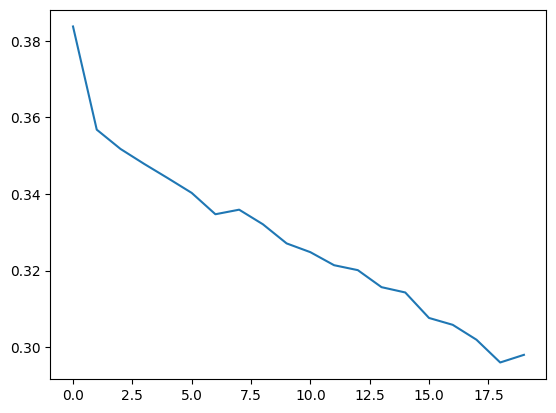

In [109]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

### Generate Notes

First, you need to provide a starting sequence of notes
The function below generates one note from a sequence of notes.

Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The temperature parameter can be used to control the randomness of notes generated. 

In [111]:
def predict_next_note(
        notes: np.ndarray,
        model: tf.keras.Model,
        temperature: float = 1.0) -> tuple[int, float, float]: # -> indicates what you return
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

    assert temperature > 0 

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions["pitch"]
    step = predictions["step"]
    duration = predictions["duration"]

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(step, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # "step" and "duration" values hould be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

#### Now generate some notes. Play around with temperature and the starting seqeunce in next_notes

In [120]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1])
)

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end)) # * is to unpack iterables like a tuple
    input_notes = np.delete(input_notes, 0 , axis=0) # (array, index, axis 0 is row/1 is column) This code means you delete the first row in input_notes array
    input_notes = np.append(input_notes, np.expand_dims(input_note, axis=0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, "start", "end")
)

1/1 [==============================] - 0s 11ms/step


In [121]:
generated_notes.head(10)

pitch      step  duration     start        end
0     55  0.125540  0.125540  0.125540   0.251080
1     99  0.933376  0.933376  1.058916   1.992291
2     87  1.113723  1.113723  2.172638   3.286361
3     87  1.107976  1.107976  3.280615   4.388591
4     97  1.114914  1.114914  4.395529   5.510444
5     95  1.132262  1.132262  5.527791   6.660053
6     99  1.128719  1.128719  6.656510   7.785230
7     61  1.135414  1.135414  7.791924   8.927338
8     72  1.071987  1.071987  8.863911   9.935898
9     48  1.094635  1.094635  9.958546  11.053181

In [122]:
out_file = "output.mid"
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name
)
display_audio(out_pm)

#### <<<< Below, I think they are the code which I asked openAI to be useful for toto.mid file>>>>

In [105]:
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

# # Sampling rate for audio playback
# _SAMPLING_RATE = 16000


# data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/toto.mid')
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'toto.mid',
#       origin='https://www.midiworld.com/download/5024',
#       extract=True,
#       cache_dir='.', cache_subdir='data',
#   )

# #The data above contains 1200+ Midi files
# filenames = str(data_dir)

# #Process a MIDI file
# sample_file = filenames
# print(sample_file)
# print(sample_file)

# # generate a prettyMIDI object for the sample MIDI file
# pm = pretty_midi.PrettyMIDI(sample_file)

In [106]:
# raw_notes, instrument_names_out = midi_to_notes(sample_file)
# print(instrument_names_out)
# raw_notes.head()


In [107]:
# def notes_to_midi(notes_df: pd.DataFrame, out_file: str, instrument_name: List[str]) -> pretty_midi.PrettyMIDI:
#     # Create a new PrettyMIDI object
#     pm = pretty_midi.PrettyMIDI()
#     print(instrument_name)
#     # Create a dictionary to store the instruments
#     instruments = {}

#     # Add notes to the corresponding instruments
#     for index, row in notes_df.iterrows():
#         pitch = int(row['pitch'])
#         start = float(row['start'])
#         end = float(row['end'])
#         duration = float(row['duration'])
#         step = float(row['step'])

#         # Find the instrument index based on the step value
#         instrument_index = int(index % len(instrument_name))

#         if instrument_index in instruments:
#             # If the instrument already exists, use it
#             instrument = instruments[instrument_index]
#         else:
#             # Create a new instrument
#             if instrument_index == 9:
#                 # If it's a bass drum instrument, create a new drum instrument
#                 instrument = pretty_midi.Instrument(program=0, is_drum=True)
#             elif instrument_index == 10:
#                 # If it's a snare drum instrument, create a new drum instrument
#                 instrument = pretty_midi.Instrument(program=0, is_drum=True)
#             elif instrument_index == 11:
#                 # If it's a snare drum instrument, create a new drum instrument
#                 instrument = pretty_midi.Instrument(program=0, is_drum=True)
#             else:
#                 # For non-drum instruments, create a new melody instrument
#                 program = pretty_midi.instrument_name_to_program(instrument_name[instrument_index])
#                 instrument = pretty_midi.Instrument(program=program)
            
#             # Store the instrument in the dictionary
#             instruments[instrument_index] = instrument

#         # Create a new note
#         note = pretty_midi.Note(
#             velocity=100, pitch=pitch, start=start, end=end
#         )

#         # Add the note to the instrument
#         instrument.notes.append(note)

#     # Add the instruments to the MIDI object
#     for instrument in instruments.values():
#         pm.instruments.append(instrument)

#     # Write the MIDI object to a file
#     pm.write(out_file)

#     # Return the created PrettyMIDI object
#     return pm


In [108]:
# """How the map() works. You do not pass in an argument for filterOut2, 
# map() automatically dose so from data for you"""

# data = [[1,2,3,5],[1,2,5,2],[3,5,2,8],[6,3,1,2],[5,3,2,5],[4,1,2,5] ]
# def filterOut2(line):
#     return [x for x in line if x !=2]

# print(list(map(filterOut2, data)))